# Introduction


word embeddings are dense vectors that represent words and they are what we use as input to our language models. These embeddings are trained separately than our models on lots of text..that could be text from Wikipedia, from other places on the internet or specialized content, like SPDs.


When we train our models we can adjust these embeddings, but it's usually better to freeze them since allowing them to change creates too many flexible parameters and leads us to over-fit easily.


If we normalize our text before hand we can control what our word embeddings are eg we could convert words like 
`OOP` to `out of pocket` or whatever we wish, it could be `outofpocket`, as long as we stick to this convention. This tutorial we learn how to creat our own embeddings or word representations.


This notebook trains on wikipedia data but eventually we'll collect our own texts with the help of Dani et al. and see how certain terms change!

# Word Embedding Tutorial: Skip-gram word2vec

In this notebook, I'll lead you through using TensorFlow to implement the word2vec algorithm using the skip-gram architecture. By implementing this, you'll learn about embedding words for use in natural language processing. This will come in handy when dealing with things like machine translation.

## Readings

Here are the resources I used to build this notebook. I suggest reading these either beforehand or while you're working on this material.


* http://ruder.io/word-embeddings-1/

* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of word2vec from Chris McCormick 
* [First word2vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* An [implementation of word2vec](http://www.thushv.com/natural_language_processing/word2vec-part-1-nlp-with-deep-learning-with-tensorflow-skip-gram/) from Thushan Ganegedara
* TensorFlow [word2vec tutorial](https://www.tensorflow.org/tutorials/word2vec)

an interesting with improvements:
* Distributed Representations of Words and Phrases and their Compositionality
http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf

## Word embeddings

When you're dealing with words in text, you end up with tens of thousands of classes to predict, one for each word. Trying to one-hot encode these words is massively inefficient, you'll have one element set to 1 and the other 50,000 set to 0. The matrix multiplication going into the first hidden layer will have almost all of the resulting values be zero. This a huge waste of computation. 

![one-hot encodings](assets/one_hot_encoding.png)

To solve this problem and greatly increase the efficiency of our networks, we use what are called embeddings. Embeddings are just a fully connected layer like you've seen before. We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. We can do this because the multiplication of a one-hot encoded vector with a matrix returns the row of the matrix corresponding the index of the "on" input unit.

![lookup](assets/lookup_matrix.png)

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an **embedding lookup** and the number of hidden units is the **embedding dimension**.

<img src='assets/tokenize_lookup.png' width=500>
 
There is nothing magical going on here. The embedding lookup table is just a weight matrix. The embedding layer is just a hidden layer. The lookup is just a shortcut for the matrix multiplication. The lookup table is trained just like any weight matrix as well.

Embeddings aren't only used for words of course. You can use them for any model where you have a massive number of classes. A particular type of model called **Word2Vec** uses the embedding layer to find vector representations of words that contain semantic meaning.



## Word2Vec

The word2vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words. Words that show up in similar contexts, such as "black", "white", and "red" will have vectors near each other. There are two architectures for implementing word2vec, CBOW (Continuous Bag-Of-Words) and Skip-gram.

<img src="assets/word2vec_architectures.png" width="500">

In this implementation, we'll be using the skip-gram architecture because it performs better than CBOW. Here, we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts.

First up, importing packages.

In [1]:
import time

import numpy as np
import tensorflow as tf

import utils

Load the [text8 dataset](http://mattmahoney.net/dc/textdata.html), a file of cleaned up Wikipedia articles from Matt Mahoney. The next cell will download the data set to the `data` folder. Then you can extract it and delete the archive file to save storage space.

In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()

Text8 Dataset: 31.4MB [03:12, 163KB/s]                             


In [33]:
type(text)

str

In [31]:
len(text)

100000000

## Preprocessing

Here I'm fixing up the text to make training easier. This comes from the `utils` module I wrote. The `preprocess` function coverts any punctuation into tokens, so a period is changed to ` <PERIOD> `. In this data set, there aren't any periods, but it will help in other NLP problems. I'm also removing all words that show up five or fewer times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. If you want to write your own functions for this stuff, go for it.

In [3]:
# NB that words have a natural (meaningful) order as the occur in language and have context..that we'll use later!
words = utils.preprocess(text)

In [7]:
# NB notice that these are just strings..so we can preprocess our text to any specification we wish!
print(words[:100])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to', 'describe', 'any', 'act', 'that', 'used', 'violent', 'means', 'to', 'destroy', 'the', 'organization', 'of', 'society', 'it', 'has', 'also', 'been', 'taken', 'up', 'as', 'a', 'positive', 'label', 'by', 'self', 'defined', 'anarchists', 'the', 'word', 'anarchism', 'is', 'derived', 'from', 'the', 'greek', 'without', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'as', 'a', 'political', 'philosophy', 'is', 'the', 'belief', 'that', 'rulers', 'are', 'unnecessary', 'and', 'should', 'be', 'abolished', 'although', 'there', 'are', 'differing']


In [8]:
print("Total words:  {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words:  16680599
Unique words: 63641


And here I'm creating dictionaries to covert words to integers and backwards, integers to words. The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1 and so on. The words are converted to integers and stored in the list `int_words`.

In [9]:
# the dictionary my be ordered by frequency but the int_word order is same as text
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

### Special WC vocabulary terms we'd like to track

In [12]:
benefits_terms = ['insurance','maximum','claim','claims','policy','doi','dime']
non_benefit_terms = ['man', 'woman','cat','dog']
print('Benefit terms:')
for i in benefits_terms:
    print('term:', i, 'vocab integer:\t', vocab_to_int[i])
    
print()
print('Non Benefit terms:')
for i in non_benefit_terms:
    print('term:', i, 'vocab integer:\t', vocab_to_int[i])
    
benefits_terms_ints = [vocab_to_int[i] for i in benefits_terms]
non_benefits_terms_ints = [vocab_to_int[i] for i in non_benefit_terms]

Benefit terms:
term: insurance vocab integer:	 3426
term: maximum vocab integer:	 2094
term: claim vocab integer:	 848
term: claims vocab integer:	 903
term: policy vocab integer:	 738
term: doi vocab integer:	 31154
term: dime vocab integer:	 22175

Non Benefit terms:
term: man vocab integer:	 242
term: woman vocab integer:	 1012
term: cat vocab integer:	 2600
term: dog vocab integer:	 1901


In [13]:
my_terms = ['injury','compensation','worker','workers']
for i in my_terms:
    print('term:', i, 'vocab integer:\t', vocab_to_int[i])
my_terms_ints = [vocab_to_int[i] for i in my_terms]

term: injury vocab integer:	 4062
term: compensation vocab integer:	 7640
term: worker vocab integer:	 5476
term: workers vocab integer:	 1555


In [14]:
# note that a lot of terms we want are not in the dataset
print('Nice to have terms:')
nice_terms = ['D1','PTD','TTD']
for i in nice_terms:
    print('term:',i, '\tin set:\t', i in set(words))

Nice to have terms:
term: D1 	in set:	 False
term: PTD 	in set:	 False
term: TTD 	in set:	 False


## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

I'm going to leave this up to you as an exercise. Check out my solution to see how I did it.

> **Exercise:** Implement subsampling for the words in `int_words`. That is, go through `int_words` and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is that probability that a word is discarded. Assign the subsampled data to `train_words`.

In [15]:
from collections import Counter
import random

threshold = 1e-5
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

## Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $< 1; C >$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

> **Exercise:** Implement a function `get_target` that receives a list of words, an index, and a window size, then returns a list of words in the window around the index. Make sure to use the algorithm described above, where you chose a random number of words to from the window.

In [16]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)

Here's a function that returns batches for our network. The idea is that it grabs `batch_size` words from a words list. Then for each of those words, it gets the target words in the window. I haven't found a way to pass in a random number of target words and get it to work with the architecture, so I make one row per input-target pair. This is a generator function by the way, helps save memory.

In [17]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

## Building the graph

From [Chris McCormick's blog](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/), we can see the general structure of our network.
![embedding_network](./assets/skip_gram_net_arch.png)

The input words are passed in as one-hot encoded vectors. This will go into a hidden layer of linear units, then into a softmax layer. We'll use the softmax layer to make a prediction like normal.

The idea here is to train the hidden layer weight matrix to find efficient representations for our words. We can discard the softmax layer becuase we don't really care about making predictions with this network. We just want the embedding matrix so we can use it in other networks we build from the dataset.

I'm going to have you build the graph in stages now. First off, creating the `inputs` and `labels` placeholders like normal.

> **Exercise:** Assign `inputs` and `labels` using `tf.placeholder`. We're going to be passing in integers, so set the data types to `tf.int32`. The batches we're passing in will have varying sizes, so set the batch sizes to [`None`]. To make things work later, you'll need to set the second dimension of `labels` to `None` or `1`.

In [18]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')

## Embedding



The embedding matrix has a size of the number of words by the number of units in the hidden layer. So, if you have 10,000 words and 300 hidden units, the matrix will have size $10,000 \times 300$. Remember that we're using tokenized data for our inputs, usually as integers, where the number of tokens is the number of words in our vocabulary.


> **Exercise:** Tensorflow provides a convenient function [`tf.nn.embedding_lookup`](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup) that does this lookup for us. You pass in the embedding matrix and a tensor of integers, then it returns rows in the matrix corresponding to those integers. Below, set the number of embedding features you'll use (200 is a good start), create the embedding matrix variable, and use `tf.nn.embedding_lookup` to get the embedding tensors. For the embedding matrix, I suggest you initialize it with a uniform random numbers between -1 and 1 using [tf.random_uniform](https://www.tensorflow.org/api_docs/python/tf/random_uniform).

In [19]:
n_vocab = len(int_to_vocab)
n_embedding = 200 # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)

## Negative sampling



For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct label, but only a small number of incorrect labels. This is called ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). Tensorflow has a convenient function to do this, [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss).

> **Exercise:** Below, create weights and biases for the softmax layer. Then, use [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss) to calculate the loss. Be sure to read the documentation to figure out how it works.

In [20]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

## Validation

This code is from Thushan Ganegedara's implementation. Here we're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [21]:
random.sample(range(10),4)

[9, 3, 1, 4]

In [22]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    # add our special terms here
    valid_examples = np.append(valid_examples,benefits_terms_ints)
    valid_examples = np.append(valid_examples,non_benefits_terms_ints)
    valid_examples = np.append(valid_examples,my_terms_ints)
    
    valid_size = valid_size + len(benefits_terms_ints) + len(non_benefits_terms_ints) + len(my_terms_ints)
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [23]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

In [24]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/10 Iteration: 100 Avg. Training loss: 5.6678 0.2604 sec/batch
Epoch 1/10 Iteration: 200 Avg. Training loss: 5.6081 0.2675 sec/batch
Epoch 1/10 Iteration: 300 Avg. Training loss: 5.5257 0.2765 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 5.6012 0.2740 sec/batch
Epoch 1/10 Iteration: 500 Avg. Training loss: 5.5036 0.2717 sec/batch
Epoch 1/10 Iteration: 600 Avg. Training loss: 5.5181 0.2740 sec/batch
Epoch 1/10 Iteration: 700 Avg. Training loss: 5.5589 0.2697 sec/batch
Epoch 1/10 Iteration: 800 Avg. Training loss: 5.5185 0.2738 sec/batch
Epoch 1/10 Iteration: 900 Avg. Training loss: 5.4680 0.2762 sec/batch
Epoch 1/10 Iteration: 1000 Avg. Training loss: 5.4273 0.2735 sec/batch
Nearest to between: anatomically, openings, declarative, punisher, akkadians, alec, phi, libro,
Nearest to into: protestants, electrical, precognition, melcher, komodo, kwaidan, gutter, knossos,
Nearest to also: paradoxes, lovecraftian, numbing, syriacs, dubious, fasts, francoist, heat,
Nearest to 

Nearest to workers: fcs, copyrighted, kuan, kazakh, franck, unchanged, participate, eea,
Epoch 1/10 Iteration: 3100 Avg. Training loss: 4.7946 0.2839 sec/batch
Epoch 1/10 Iteration: 3200 Avg. Training loss: 4.7598 0.2743 sec/batch
Epoch 1/10 Iteration: 3300 Avg. Training loss: 4.7458 0.2740 sec/batch
Epoch 1/10 Iteration: 3400 Avg. Training loss: 4.7116 0.2703 sec/batch
Epoch 1/10 Iteration: 3500 Avg. Training loss: 4.7273 0.2764 sec/batch
Epoch 1/10 Iteration: 3600 Avg. Training loss: 4.7004 0.2774 sec/batch
Epoch 1/10 Iteration: 3700 Avg. Training loss: 4.7070 0.2926 sec/batch
Epoch 1/10 Iteration: 3800 Avg. Training loss: 4.7296 0.2753 sec/batch
Epoch 1/10 Iteration: 3900 Avg. Training loss: 4.7048 0.2766 sec/batch
Epoch 1/10 Iteration: 4000 Avg. Training loss: 4.6560 0.2756 sec/batch
Nearest to between: openings, anatomically, asserts, libro, declarative, returned, alec, trait,
Nearest to into: protestants, pneumonia, categorical, fortification, electrical, precognition, homomorphi

Nearest to worker: steiner, other, fouquet, scuola, satirist, afloat, florida, involving,
Nearest to workers: fcs, copyrighted, kazakh, kuan, franck, synchronize, klang, blackwood,
Epoch 2/10 Iteration: 6100 Avg. Training loss: 4.4474 0.2828 sec/batch
Epoch 2/10 Iteration: 6200 Avg. Training loss: 4.4199 0.2815 sec/batch
Epoch 2/10 Iteration: 6300 Avg. Training loss: 4.4456 0.2776 sec/batch
Epoch 2/10 Iteration: 6400 Avg. Training loss: 4.3970 0.2810 sec/batch
Epoch 2/10 Iteration: 6500 Avg. Training loss: 4.4307 0.2673 sec/batch
Epoch 2/10 Iteration: 6600 Avg. Training loss: 4.4304 0.2750 sec/batch
Epoch 2/10 Iteration: 6700 Avg. Training loss: 4.3598 0.2783 sec/batch
Epoch 2/10 Iteration: 6800 Avg. Training loss: 4.3978 0.2774 sec/batch
Epoch 2/10 Iteration: 6900 Avg. Training loss: 4.3867 0.2871 sec/batch
Epoch 2/10 Iteration: 7000 Avg. Training loss: 4.3558 0.3091 sec/batch
Nearest to between: openings, asserts, libro, punisher, anatomically, declarative, orosius, antennae,
Nearest

Nearest to compensation: physicians, zachariah, moi, prosecutor, timid, feuds, guerilla, expire,
Nearest to worker: steiner, other, scuola, fouquet, involving, blacklisting, afloat, florida,
Nearest to workers: fcs, klang, boosting, legality, kazakh, copyrighted, synchronize, tubulin,
Epoch 2/10 Iteration: 9100 Avg. Training loss: 4.2973 0.2881 sec/batch
Epoch 2/10 Iteration: 9200 Avg. Training loss: 4.2967 0.2904 sec/batch
Epoch 3/10 Iteration: 9300 Avg. Training loss: 4.3311 0.1396 sec/batch
Epoch 3/10 Iteration: 9400 Avg. Training loss: 4.2419 0.2587 sec/batch
Epoch 3/10 Iteration: 9500 Avg. Training loss: 4.2308 0.2648 sec/batch
Epoch 3/10 Iteration: 9600 Avg. Training loss: 4.2220 0.2687 sec/batch
Epoch 3/10 Iteration: 9700 Avg. Training loss: 4.1993 0.2712 sec/batch
Epoch 3/10 Iteration: 9800 Avg. Training loss: 4.1979 0.2688 sec/batch
Epoch 3/10 Iteration: 9900 Avg. Training loss: 4.2084 0.2791 sec/batch
Epoch 3/10 Iteration: 10000 Avg. Training loss: 4.1716 0.2707 sec/batch
Nea

Nearest to between: libro, asserts, openings, bipyramids, antennae, conformance, eduskunta, entities,
Nearest to into: komodo, enjoined, consisted, wackyland, knossos, fortification, gutter, piano,
Nearest to also: underpin, umlauts, definiendum, lovecraftian, truthfully, leaven, part, altogether,
Nearest to its: thermal, market, astounding, fanlisting, colorings, tensors, pastorius, postage,
Nearest to this: take, sejanus, orient, guignol, applying, plainchant, longbowman, disregards,
Nearest to they: homes, nayla, trying, not, altars, orgasm, beaten, cobra,
Nearest to when: transporter, insurrection, bihar, cytokines, election, heavyweight, shoes, recount,
Nearest to up: wouldn, moonset, kraken, takes, gloves, feigning, kword, darkened,
Nearest to accepted: belligerent, regards, harney, reform, promptly, eavesdrop, hurling, dpg,
Nearest to event: progressions, while, hydrophobic, proprioception, tricycle, crankshaft, calming, bridges,
Nearest to engine: dv, harpers, selden, widehat, 

Epoch 4/10 Iteration: 14100 Avg. Training loss: 4.0794 0.2217 sec/batch
Epoch 4/10 Iteration: 14200 Avg. Training loss: 4.0741 0.2452 sec/batch
Epoch 4/10 Iteration: 14300 Avg. Training loss: 4.0998 0.2336 sec/batch
Epoch 4/10 Iteration: 14400 Avg. Training loss: 4.0705 0.2183 sec/batch
Epoch 4/10 Iteration: 14500 Avg. Training loss: 4.0770 0.2137 sec/batch
Epoch 4/10 Iteration: 14600 Avg. Training loss: 4.0325 0.2221 sec/batch
Epoch 4/10 Iteration: 14700 Avg. Training loss: 4.0874 0.2165 sec/batch
Epoch 4/10 Iteration: 14800 Avg. Training loss: 4.1121 0.2180 sec/batch
Epoch 4/10 Iteration: 14900 Avg. Training loss: 4.1219 0.2258 sec/batch
Epoch 4/10 Iteration: 15000 Avg. Training loss: 3.9938 0.2125 sec/batch
Nearest to between: openings, asserts, libro, bipyramids, conformance, antennae, returned, eduskunta,
Nearest to into: knossos, enjoined, consisted, komodo, wackyland, fortification, cringely, commune,
Nearest to also: lovecraftian, underpin, umlauts, part, definiendum, leaven, a

Epoch 4/10 Iteration: 17100 Avg. Training loss: 4.0284 0.2420 sec/batch
Epoch 4/10 Iteration: 17200 Avg. Training loss: 4.0349 0.2031 sec/batch
Epoch 4/10 Iteration: 17300 Avg. Training loss: 4.0340 0.2075 sec/batch
Epoch 4/10 Iteration: 17400 Avg. Training loss: 4.0522 0.2144 sec/batch
Epoch 4/10 Iteration: 17500 Avg. Training loss: 4.0968 0.2140 sec/batch
Epoch 4/10 Iteration: 17600 Avg. Training loss: 4.1370 0.2151 sec/batch
Epoch 4/10 Iteration: 17700 Avg. Training loss: 4.1325 0.2143 sec/batch
Epoch 4/10 Iteration: 17800 Avg. Training loss: 4.0293 0.2193 sec/batch
Epoch 4/10 Iteration: 17900 Avg. Training loss: 4.0299 0.2132 sec/batch
Epoch 4/10 Iteration: 18000 Avg. Training loss: 4.0508 0.2130 sec/batch
Nearest to between: libro, bipyramids, ojibwe, returned, asserts, hamiltonian, eduskunta, rasul,
Nearest to into: consisted, knossos, gutter, enjoined, insuring, megalopolis, skid, keeshonden,
Nearest to also: allophonic, definiendum, lovecraftian, underpin, common, umlauts, lori

Epoch 5/10 Iteration: 20100 Avg. Training loss: 3.9794 0.2142 sec/batch
Epoch 5/10 Iteration: 20200 Avg. Training loss: 3.9964 0.2178 sec/batch
Epoch 5/10 Iteration: 20300 Avg. Training loss: 3.9783 0.2180 sec/batch
Epoch 5/10 Iteration: 20400 Avg. Training loss: 4.0169 0.2113 sec/batch
Epoch 5/10 Iteration: 20500 Avg. Training loss: 4.0198 0.2089 sec/batch
Epoch 5/10 Iteration: 20600 Avg. Training loss: 3.9608 0.2161 sec/batch
Epoch 5/10 Iteration: 20700 Avg. Training loss: 3.9806 0.2116 sec/batch
Epoch 5/10 Iteration: 20800 Avg. Training loss: 3.9857 0.2189 sec/batch
Epoch 5/10 Iteration: 20900 Avg. Training loss: 3.9922 0.2199 sec/batch
Epoch 5/10 Iteration: 21000 Avg. Training loss: 4.0087 0.2217 sec/batch
Nearest to between: bipyramids, libro, hamiltonian, asserts, returned, openings, varying, ascorbate,
Nearest to into: consisted, knossos, gutter, insuring, cringely, altitude, enjoined, bowery,
Nearest to also: list, the, underpin, common, lovecraftian, cbe, breda, part,
Nearest 

Epoch 5/10 Iteration: 23100 Avg. Training loss: 4.0137 0.2169 sec/batch
Epoch 6/10 Iteration: 23200 Avg. Training loss: 3.9813 0.1795 sec/batch
Epoch 6/10 Iteration: 23300 Avg. Training loss: 3.9225 0.2233 sec/batch
Epoch 6/10 Iteration: 23400 Avg. Training loss: 3.9390 0.2208 sec/batch
Epoch 6/10 Iteration: 23500 Avg. Training loss: 3.9909 0.2117 sec/batch
Epoch 6/10 Iteration: 23600 Avg. Training loss: 3.9061 0.2155 sec/batch
Epoch 6/10 Iteration: 23700 Avg. Training loss: 3.9480 0.2124 sec/batch
Epoch 6/10 Iteration: 23800 Avg. Training loss: 3.8992 0.2165 sec/batch
Epoch 6/10 Iteration: 23900 Avg. Training loss: 3.9758 0.1986 sec/batch
Epoch 6/10 Iteration: 24000 Avg. Training loss: 3.9635 0.2048 sec/batch
Nearest to between: openings, bipyramids, ojibwe, decreased, asserts, libro, himalaya, republika,
Nearest to into: consisted, knossos, the, of, altitude, gutter, bismarck, enjoined,
Nearest to also: the, is, for, list, rectifiers, as, this, longsword,
Nearest to its: mislabeled, 

Epoch 6/10 Iteration: 26100 Avg. Training loss: 3.9284 0.2225 sec/batch
Epoch 6/10 Iteration: 26200 Avg. Training loss: 3.9480 0.2135 sec/batch
Epoch 6/10 Iteration: 26300 Avg. Training loss: 3.9502 0.2123 sec/batch
Epoch 6/10 Iteration: 26400 Avg. Training loss: 3.9136 0.2185 sec/batch
Epoch 6/10 Iteration: 26500 Avg. Training loss: 3.9412 0.2119 sec/batch
Epoch 6/10 Iteration: 26600 Avg. Training loss: 3.9988 0.2203 sec/batch
Epoch 6/10 Iteration: 26700 Avg. Training loss: 3.9151 0.2146 sec/batch
Epoch 6/10 Iteration: 26800 Avg. Training loss: 4.0487 0.2250 sec/batch
Epoch 6/10 Iteration: 26900 Avg. Training loss: 3.9693 0.2192 sec/batch
Epoch 6/10 Iteration: 27000 Avg. Training loss: 4.0119 0.2133 sec/batch
Nearest to between: himalaya, asserts, decreased, bipyramids, returned, ojibwe, the, openings,
Nearest to into: consisted, the, gutter, knossos, bowery, insuring, of, roving,
Nearest to also: the, for, of, list, is, in, as, this,
Nearest to its: mislabeled, component, cheesemakin

Epoch 7/10 Iteration: 29100 Avg. Training loss: 3.8748 0.2211 sec/batch
Epoch 7/10 Iteration: 29200 Avg. Training loss: 3.8163 0.2123 sec/batch
Epoch 7/10 Iteration: 29300 Avg. Training loss: 3.9082 0.2193 sec/batch
Epoch 7/10 Iteration: 29400 Avg. Training loss: 3.9178 0.2196 sec/batch
Epoch 7/10 Iteration: 29500 Avg. Training loss: 3.9039 0.2194 sec/batch
Epoch 7/10 Iteration: 29600 Avg. Training loss: 3.8917 0.2087 sec/batch
Epoch 7/10 Iteration: 29700 Avg. Training loss: 3.9593 0.2184 sec/batch
Epoch 7/10 Iteration: 29800 Avg. Training loss: 3.9207 0.2185 sec/batch
Epoch 7/10 Iteration: 29900 Avg. Training loss: 3.8704 0.2012 sec/batch
Epoch 7/10 Iteration: 30000 Avg. Training loss: 3.9054 0.2086 sec/batch
Nearest to between: in, the, asserts, same, of, decreased, bipyramids, magnetically,
Nearest to into: consisted, the, of, and, gutter, knossos, insuring, which,
Nearest to also: the, as, is, of, for, in, list, this,
Nearest to its: component, tensors, it, mislabeled, which, ofdm,

Epoch 7/10 Iteration: 32100 Avg. Training loss: 3.9061 0.2284 sec/batch
Epoch 7/10 Iteration: 32200 Avg. Training loss: 3.9171 0.2202 sec/batch
Epoch 7/10 Iteration: 32300 Avg. Training loss: 3.9126 0.2225 sec/batch
Epoch 8/10 Iteration: 32400 Avg. Training loss: 3.9431 0.0685 sec/batch
Epoch 8/10 Iteration: 32500 Avg. Training loss: 3.8860 0.2234 sec/batch
Epoch 8/10 Iteration: 32600 Avg. Training loss: 3.8684 0.2240 sec/batch
Epoch 8/10 Iteration: 32700 Avg. Training loss: 3.8699 0.2284 sec/batch
Epoch 8/10 Iteration: 32800 Avg. Training loss: 3.8678 0.2255 sec/batch
Epoch 8/10 Iteration: 32900 Avg. Training loss: 3.8563 0.2222 sec/batch
Epoch 8/10 Iteration: 33000 Avg. Training loss: 3.8930 0.2258 sec/batch
Nearest to between: same, the, himalaya, decreased, in, bipyramids, of, rgya,
Nearest to into: the, consisted, of, insuring, and, knossos, which, gutter,
Nearest to also: the, is, of, as, in, for, list, this,
Nearest to its: it, component, the, from, mislabeled, formerly, as, way

Epoch 8/10 Iteration: 35100 Avg. Training loss: 3.8634 0.2405 sec/batch
Epoch 8/10 Iteration: 35200 Avg. Training loss: 3.8747 0.2330 sec/batch
Epoch 8/10 Iteration: 35300 Avg. Training loss: 3.8828 0.2155 sec/batch
Epoch 8/10 Iteration: 35400 Avg. Training loss: 3.8900 0.2112 sec/batch
Epoch 8/10 Iteration: 35500 Avg. Training loss: 3.8702 0.2135 sec/batch
Epoch 8/10 Iteration: 35600 Avg. Training loss: 3.8590 0.2129 sec/batch
Epoch 8/10 Iteration: 35700 Avg. Training loss: 3.8646 0.2184 sec/batch
Epoch 8/10 Iteration: 35800 Avg. Training loss: 3.9009 0.2176 sec/batch
Epoch 8/10 Iteration: 35900 Avg. Training loss: 3.9042 0.2178 sec/batch
Epoch 8/10 Iteration: 36000 Avg. Training loss: 3.9151 0.2147 sec/batch
Nearest to between: same, the, rgya, himalaya, in, asserts, with, barbadian,
Nearest to into: the, consisted, of, insuring, bowery, then, by, gutter,
Nearest to also: as, for, the, in, is, of, this, list,
Nearest to its: it, component, as, which, way, by, the, formerly,
Nearest t

Epoch 9/10 Iteration: 38100 Avg. Training loss: 3.8413 0.2327 sec/batch
Epoch 9/10 Iteration: 38200 Avg. Training loss: 3.7702 0.2259 sec/batch
Epoch 9/10 Iteration: 38300 Avg. Training loss: 3.8095 0.2122 sec/batch
Epoch 9/10 Iteration: 38400 Avg. Training loss: 3.7771 0.2114 sec/batch
Epoch 9/10 Iteration: 38500 Avg. Training loss: 3.8165 0.2153 sec/batch
Epoch 9/10 Iteration: 38600 Avg. Training loss: 3.8711 0.2151 sec/batch
Epoch 9/10 Iteration: 38700 Avg. Training loss: 3.8393 0.2155 sec/batch
Epoch 9/10 Iteration: 38800 Avg. Training loss: 3.8412 0.2171 sec/batch
Epoch 9/10 Iteration: 38900 Avg. Training loss: 3.9045 0.2176 sec/batch
Epoch 9/10 Iteration: 39000 Avg. Training loss: 3.8646 0.2176 sec/batch
Nearest to between: same, in, a, the, of, differences, rgya, first,
Nearest to into: and, the, consisted, a, of, in, which, by,
Nearest to also: as, in, of, a, the, is, for, to,
Nearest to its: it, component, as, which, with, the, formerly, in,
Nearest to this: the, also, it, an,

Epoch 9/10 Iteration: 41100 Avg. Training loss: 3.8538 0.2281 sec/batch
Epoch 9/10 Iteration: 41200 Avg. Training loss: 3.8176 0.2257 sec/batch
Epoch 9/10 Iteration: 41300 Avg. Training loss: 3.8003 0.2285 sec/batch
Epoch 9/10 Iteration: 41400 Avg. Training loss: 3.8939 0.2287 sec/batch
Epoch 9/10 Iteration: 41500 Avg. Training loss: 3.8421 0.2280 sec/batch
Epoch 9/10 Iteration: 41600 Avg. Training loss: 3.8967 0.2207 sec/batch
Epoch 10/10 Iteration: 41700 Avg. Training loss: 3.8843 0.1878 sec/batch
Epoch 10/10 Iteration: 41800 Avg. Training loss: 3.8447 0.2231 sec/batch
Epoch 10/10 Iteration: 41900 Avg. Training loss: 3.8383 0.2224 sec/batch
Epoch 10/10 Iteration: 42000 Avg. Training loss: 3.8519 0.2183 sec/batch
Nearest to between: same, a, in, the, with, of, himalaya, rgya,
Nearest to into: and, the, of, in, by, consisted, a, insuring,
Nearest to also: the, as, is, in, of, a, for, and,
Nearest to its: it, the, component, as, with, which, s, formerly,
Nearest to this: the, also, an, 

Epoch 10/10 Iteration: 44100 Avg. Training loss: 3.8417 0.2314 sec/batch
Epoch 10/10 Iteration: 44200 Avg. Training loss: 3.8652 0.2278 sec/batch
Epoch 10/10 Iteration: 44300 Avg. Training loss: 3.8252 0.2227 sec/batch
Epoch 10/10 Iteration: 44400 Avg. Training loss: 3.8303 0.2274 sec/batch
Epoch 10/10 Iteration: 44500 Avg. Training loss: 3.8632 0.2266 sec/batch
Epoch 10/10 Iteration: 44600 Avg. Training loss: 3.8455 0.2292 sec/batch
Epoch 10/10 Iteration: 44700 Avg. Training loss: 3.8540 0.2283 sec/batch
Epoch 10/10 Iteration: 44800 Avg. Training loss: 3.8265 0.2271 sec/batch
Epoch 10/10 Iteration: 44900 Avg. Training loss: 3.8271 0.2279 sec/batch
Epoch 10/10 Iteration: 45000 Avg. Training loss: 3.8326 0.2262 sec/batch
Nearest to between: same, with, a, in, the, of, so, way,
Nearest to into: the, and, of, in, by, a, which, with,
Nearest to also: the, in, for, as, of, a, is, and,
Nearest to its: it, the, in, which, component, as, s, with,
Nearest to this: the, also, an, it, a, is, in, 

Restore the trained network if you need to:

In [25]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints/text8.ckpt


## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [28]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [29]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

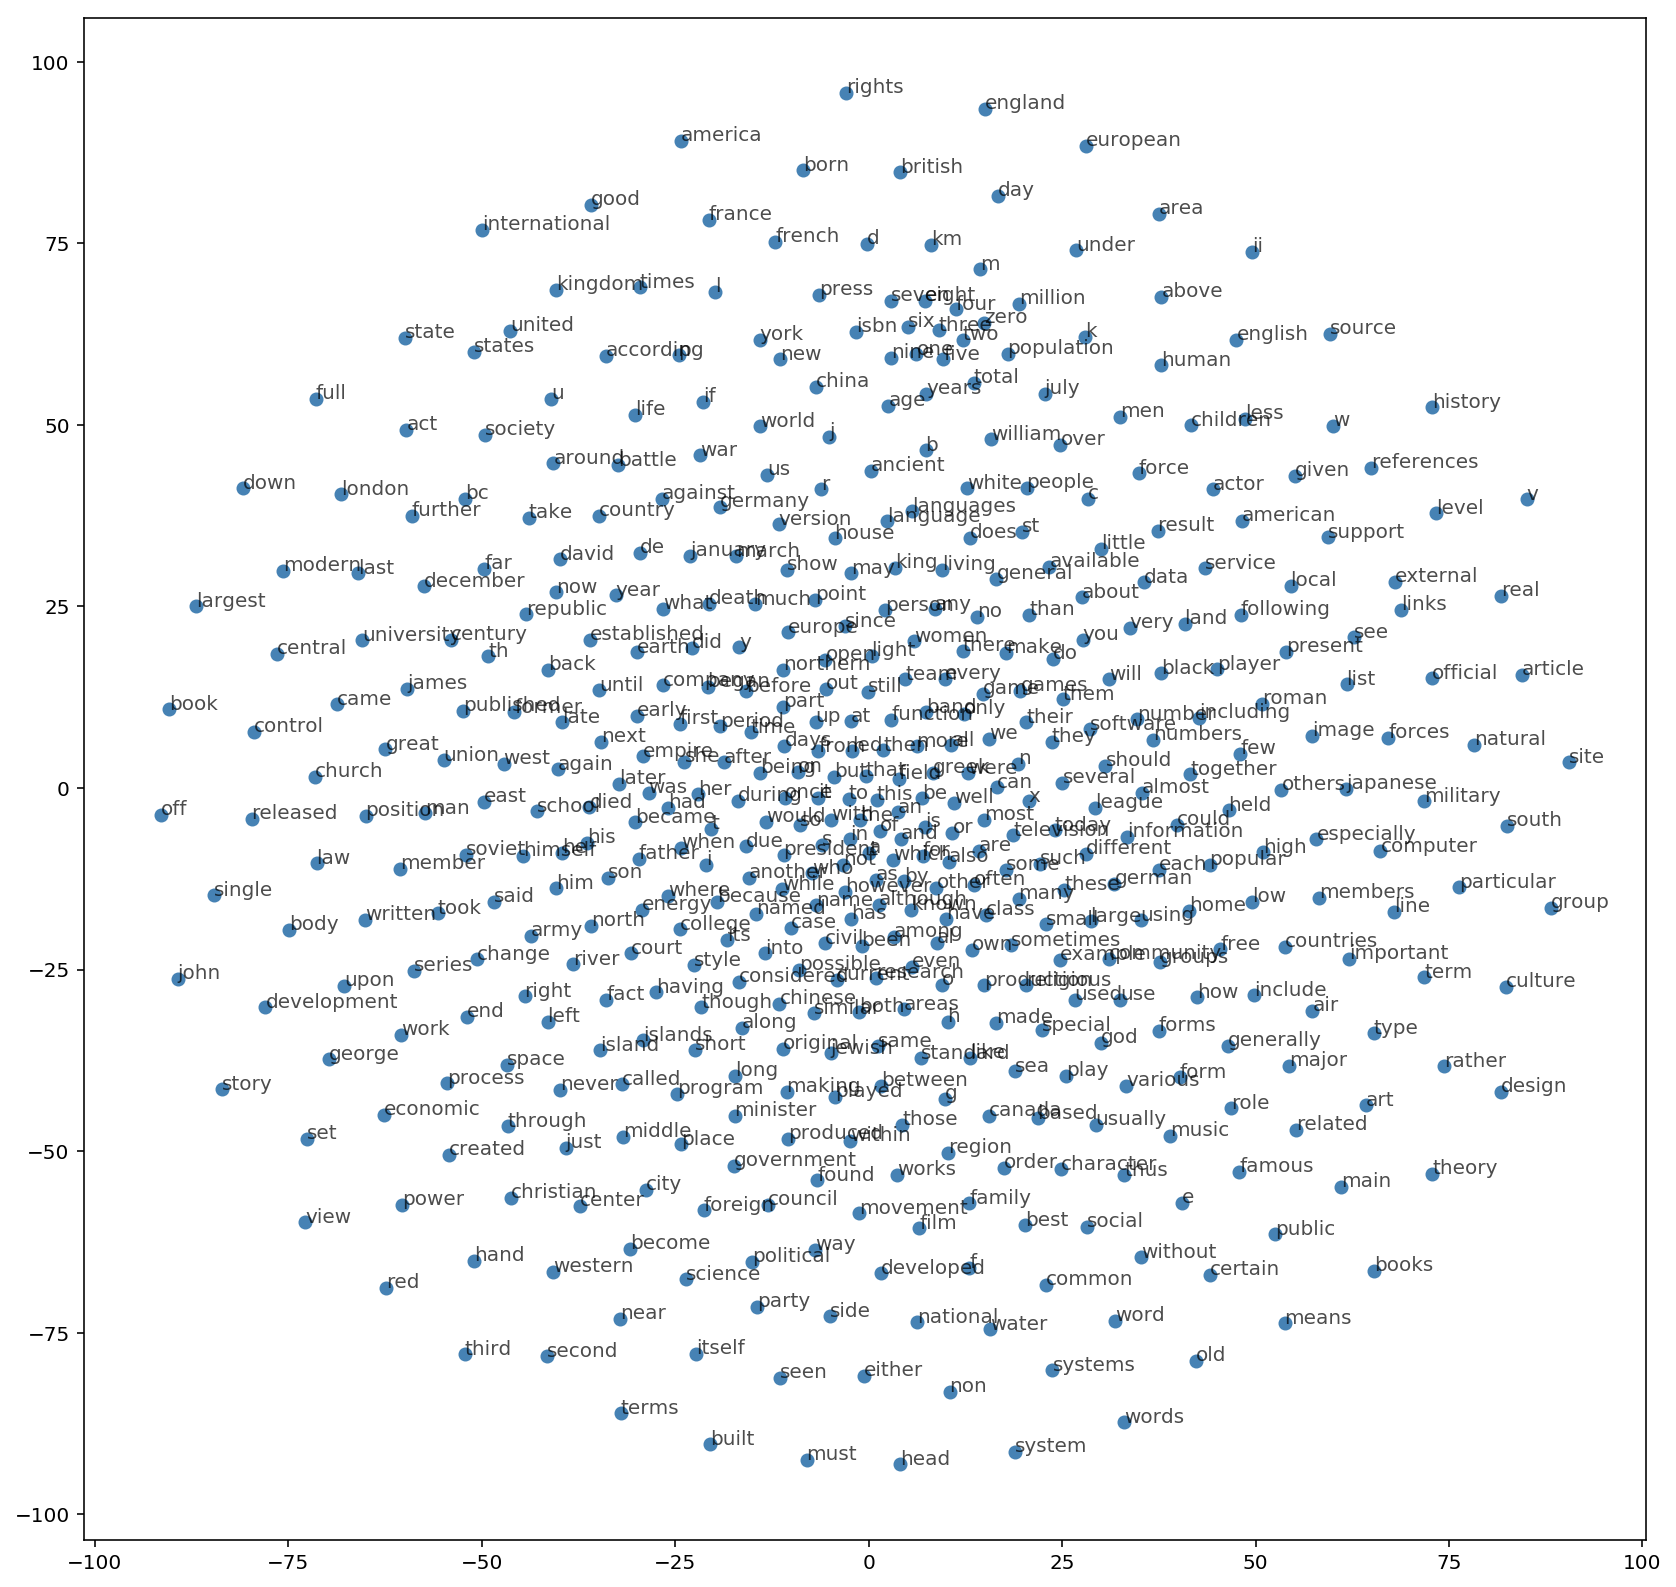

In [30]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)